# Implementation of CML wet/dry detection using CNN architecture of Polz J. [2]

__CML data:__  
Imported from pycomlink (Chwala C:): https://github.com/pycomlink/pycomlink

__Sources: All code from [2]__  
github: https://github.com/jpolz/cml_wd_pytorch/tree/main  
thesis: https://doi.org/10.5194/amt-13-3835-2020

In [1]:
import cnn
import xarray as xr               # work with arrays, also possible with pandas
import numpy as np
import torch
import torch.nn as nn
import einops
import matplotlib.pyplot as plt
import sklearn.metrics as skl

In [2]:
from sklearn.utils import shuffle
from tqdm import tqdm
from IPython.display import clear_output


### Load CML data
Import data of 500 CML links from pycomlink with 1min timestep

In [3]:
# 500 CMLs with 1 min time step
cml_set = xr.open_dataset('example_data/example_cml_data.nc', engine='netcdf4') # https://docs.xarray.dev/en/stable/generated/xarray.Dataset.html

#### Temporarily remove GPS coordinates
might add later with additional cml info for better CNN learning

In [4]:
# https://stackoverflow.com/questions/61003361/drop-coordinate-from-an-xarray-dataarray
cml_set = cml_set.reset_coords(['site_a_latitude','site_b_latitude','site_a_longitude','site_b_longitude'], drop=True)
cml_set

<xarray.Dataset> Size: 254MB
Dimensions:       (time: 15840, cml_id: 500, channel_id: 2)
Coordinates:
  * time          (time) datetime64[ns] 127kB 2018-05-10 ... 2018-05-20T23:59:00
  * cml_id        (cml_id) <U3 6kB '0' '1' '2' '3' ... '496' '497' '498' '499'
    length        (cml_id) float64 4kB ...
  * channel_id    (channel_id) <U9 72B 'channel_1' 'channel_2'
    frequency     (cml_id, channel_id) float64 8kB ...
    polarization  (cml_id, channel_id) <U1 4kB ...
Data variables:
    rsl           (channel_id, cml_id, time) float64 127MB ...
    tsl           (channel_id, cml_id, time) float64 127MB ...

### Load Reference data
Reference rain rate data from RADOLAN. With 5 min step

In [5]:
# reference RADOLAN data from pycomlink with 5 min time step
# ref = xr.open_dataset('example_data/example_areal_reference_data.nc', engine='netcdf4')
# Path averaged reference RADOLAN data aligned with all 500 CML IDs
ref_set = xr.open_dataset('example_data/example_path_averaged_reference_data.nc', engine='netcdf4')
ref_set

<xarray.Dataset> Size: 13MB
Dimensions:          (time: 3168, cml_id: 500)
Coordinates:
  * time             (time) datetime64[ns] 25kB 2018-05-10 ... 2018-05-20T23:...
  * cml_id           (cml_id) <U3 6kB '0' '1' '2' '3' ... '497' '498' '499'
Data variables:
    rainfall_amount  (time, cml_id) float64 13MB ...

#### merge cml and ref data

In [24]:
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
cml_set = cml_set.resample(time="5min").max()
cml_ch1 = cml_set.isel(channel_id=0)

xr.combine_nested([cml_ch1,ref_set], concat_dim=["cml_id", "time"])
#xr.combine_by_coords([cml_ch1,ref_set])
#xr.concat([cml_set.isel(channel_id=0),ref_set], dim="time")

# doesnt work
#data_set = xr.concat(cml_list, dim="cml_id")
#data_set
#len(cml_set.rsl)

ValueError: concat_dims has length 2 but the datasets passed are nested in a 1-dimensional structure

In [21]:
len(all.cml_id)

500

### CML data preprocessing
1. resampling data
2. replacing fault values  
3. data visualisation  
4. calculating TRSL  
5. Standardising

All from pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb

In [7]:
# replace fault data, undersample and merge cml + radar
# correct but computationally hard way
'''
cml_list = [cml_set.isel(cml_id=i) for i in range(len(cml_set.cml_id))]

for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl

#for i in range(len(data_set.cml_id)):
for i in range(len(data_set.cml_id)):
    cml_list[i] = cml_list[i].resample(time="5min").mean()
    cml_list[i] = cml_list[i].assign(ref_set.isel(cml_id=i))

cml_list[1]
'''

'\ncml_list = [cml_set.isel(cml_id=i) for i in range(len(cml_set.cml_id))]\n\nfor cml in cml_list:\n    cml[\'tsl\'] = cml.tsl.where(cml.tsl != 255.0)\n    cml[\'rsl\'] = cml.rsl.where(cml.rsl != -99.9)\n    cml[\'trsl\'] = cml.tsl - cml.rsl\n\n#for i in range(len(data_set.cml_id)):\nfor i in range(len(data_set.cml_id)):\n    cml_list[i] = cml_list[i].resample(time="5min").mean()\n    cml_list[i] = cml_list[i].assign(ref_set.isel(cml_id=i))\n\ncml_list[1]\n'

#### 1. Resample CML data to 5 min step 
from Pycomlink

In [8]:
# ? try to calculate rate of CML and reference weather data time step
# len(cml_set.time)
# len(ref_set.time)

cml_set = cml_set.resample(time="5min").max()

# watch out: mean() will destroy 255 and -99 fault values. max will destroy -99.
# !!!!!!! Need to replace them before undersampling !!!!!!!

#### 2. Turn CML data to list per CML and align with reference RADOLAN rainrate

In [9]:
# store as a list of xarrays per one CML
# From Pycomlink https://github.com/pycomlink/pycomlink/blob/master/notebooks/Basic%20CML%20processing%20workflow.ipynb
# isel and assign from xarray: https://docs.xarray.dev/en/latest/generated/xarray.Dataset.assign.html
cml_list = [None]*len(cml_set.cml_id)

for i in range(len(cml_set.cml_id)):
    cml_list[i] = cml_set.isel(cml_id=i).assign(ref_set.isel(cml_id=i))

# cml_list[1]

#### 3. Replace fault values with NaN, Calculate TRSL, add boolean Wet/dry flag

In [10]:
# replace default fault values with NaN
for cml in cml_list:
    cml['tsl'] = cml.tsl.where(cml.tsl != 255.0)
    cml['rsl'] = cml.rsl.where(cml.rsl != -99.9)
    cml['trsl'] = cml.tsl - cml.rsl
    # From reference rain rate derivate binary reference Wet/Dry signal
    cml['ref_wet_dry'] = cml.rainfall_amount.where(cml.rainfall_amount == 0, True) # ChatGPT


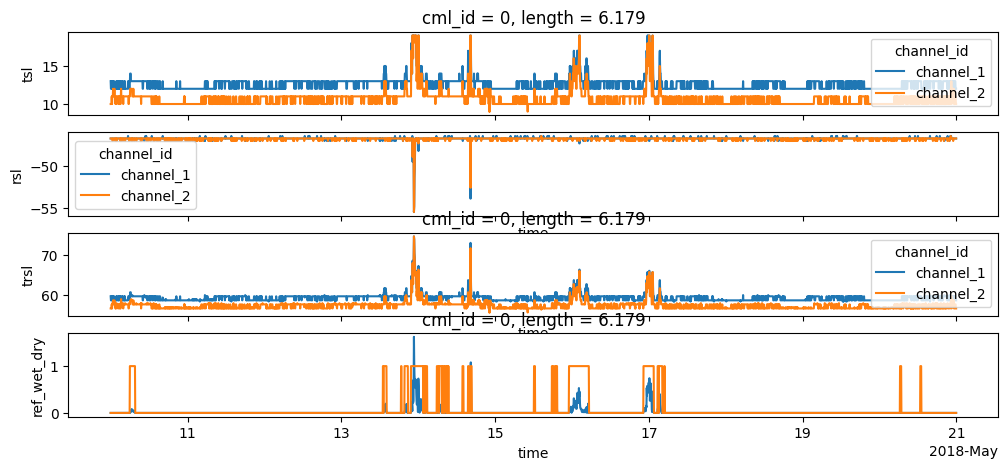

In [11]:
# Plot all input cml and reference data
fig, axs = plt.subplots(4, 1, sharex=True, figsize=(12,5))
cml_list[0].tsl.plot.line(x='time', ax=axs[0])
cml_list[0].rsl.plot.line(x='time', ax=axs[1])
cml_list[0].trsl.plot.line(x='time', ax=axs[2])
cml_list[0].rainfall_amount.plot.line(x='time', ax=axs[3])
cml_list[0].ref_wet_dry.plot.line(x='time', ax=axs[3])

axs[0].set_xlabel('')
axs[1].set_title('');

#### merge list back into xarray

In [22]:
#xr.combine_by_coords([cml_set,ref_set]dims)
#xr.concat([cml_set.isel(channel_id=0),ref_set], dim="time")

# doesnt work
#data_set = xr.concat(cml_list, dim="cml_id")
#data_set
#len(cml_list[0].rsl)

3168

#### Standardising
Subtracting the median of all available data from the preceding 72h from each time step [2] 


#### Training/Testing/validation data splitting

#### We need to make Wet/Dry periods 50:50 for the training

# ________________________________

In [13]:
# [2]
def balance_classes(a, boo):
    lsn=len(a.sample_number)
    ind = np.arange(lsn)
    ind_true = shuffle(ind[boo])
    ind_false = ind[~boo]
    ind_true = ind_true[:np.sum(~boo)]
    print(1-(2*len(ind_false)/lsn))
    return a.isel(sample_number=np.concatenate([ind_true,ind_false]))

In [14]:
#avg_ref = balance_classes(cml_list[1], ~cml_list[1].ref_wet_dry.values)

## _________________

In [15]:
ds['tl'] = ds.tl.transpose('sample_number', 'channel_id', 'timestep')

NameError: name 'ds' is not defined

In [ ]:
ds

In [ ]:
batchsize = 10
working_size = int(len(ds.sample_number)*0.8/batchsize)* batchsize

In [ ]:
working_size

In [ ]:
tl, wr = shuffle(ds.tl.values, ds.wet_radar.values)

data = tl[:working_size]
data_test = tl[working_size:]
data_out = wr[:working_size]
data_test_out = wr[working_size:]

In [ ]:
np.histogram(data_test_out)

bsp zum "abrunden" auf ganze batch size
`data = data[:int(len(data/batch_size))*batch_size]`

In [ ]:

### data as Tensor
data = torch.Tensor(data)
data_test = torch.Tensor(data_test)

data_out = torch.Tensor(data_out)
data_test_out = torch.Tensor(data_test_out)


In [ ]:

### prepare data
dataset = torch.utils.data.TensorDataset(data, data_out)
testset = torch.utils.data.TensorDataset(data_test, data_test_out)
trainloader = torch.utils.data.DataLoader(dataset, batch_size = batchsize, shuffle = True)
testloader = torch.utils.data.DataLoader(testset, batch_size = batchsize, shuffle = False)


In [ ]:
model = cnn.cnn_class()
optimizer = torch.optim.AdamW(model.parameters(), lr=0.001)


In [ ]:
epochs = 10
resume = 0

In [ ]:
if resume == 0:
    loss_dict = {}
    loss_dict['train'] = {}
    loss_dict['test'] = {}
    for key in ['train','test']:
        loss_dict[key]['loss'] = []

In [ ]:
for epoch in range(resume, epochs):
    # training
    train_losses = []
    for inputs, targets in tqdm(trainloader):
        optimizer.zero_grad()
        pred = model(inputs)
        pred = nn.Flatten(0,1)(pred)
        loss = nn.BCELoss()(pred, targets)
        loss.backward()
        optimizer.step()
        train_losses.append(loss.detach().numpy())
    loss_dict['train']['loss'].append(np.mean(train_losses))
    
    # testing
    test_losses = []
    with torch.no_grad():
        for inputs, targets in tqdm(testloader):
            pred = model(inputs)
            # pred = pred.round()
            pred = nn.Flatten(0,1)(pred)
            loss = nn.BCELoss()(pred, targets)
            test_losses.append(loss.detach().numpy())
        loss_dict['test']['loss'].append(np.mean(test_losses))
        
    # printing
    clear_output(wait=True)
    print(epoch)
    print('')
    print('train loss:', np.mean(train_losses))
    print('test loss:', np.mean(test_losses))
    print('min test loss:', np.min(loss_dict['test']['loss']))
    fig, axs = plt.subplots(1,1, figsize=(3,4))
    for key in loss_dict.keys():
        for k, key2 in enumerate(loss_dict[key].keys()):
            axs.plot(loss_dict[key][key2], label=key)
            axs.set_title(key2)
    # axs.set_yscale('log')
    plt.legend()
    plt.show()
    resume = epoch

In [ ]:
for inputs, targets in tqdm(trainloader):
    print(model(inputs))
    break

In [ ]:
### accuracy score, confusion matrix and Matthews correlation coefficient (MCC)
def eval_model(test_dataloader, model):
    predictions, actuals = list(), list()
    with torch.no_grad():
        for inputs, targets in tqdm(test_dataloader):
            pred = model(inputs)
            pred = pred.detach().numpy()
            actual = targets.numpy()
            actual = actual.reshape((len(actual), 1))
            pred = pred.round()
    
            predictions.append(pred)
            actuals.append(actual)
    predictions, actuals = np.ravel(np.vstack(predictions)), np.ravel(np.vstack(actuals))
    acc = skl.accuracy_score(actuals, predictions)
    conf_mat = skl.confusion_matrix(actual, pred, labels=[0,1], normalize='all')
    matt_cor = skl.matthews_corrcoef(actual, pred)
    return acc, conf_mat, matt_cor

In [ ]:
eval_model(testloader, model)